<a href="https://colab.research.google.com/github/akshatz/dogVision/blob/master/dog_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# End-to-end Multi-class Dog Breed Classification 

This builds end to end multi-class image classifier using TensorFlow 2.0 and TensorFlow Hub.

## 1. Problem

Identifying the breed of a dog given an image of a dog.

When I'm sitting at a cafe, and I take a photo of a dog, I want to know what breed of dog it is

## 2. Data

The data we're using is from Kaggle's dog breed identification competetion

https://www.kaggle.com/c/dog-breed-identification/data

## 3. Evaluation

The evaluation is a file with prediction probabilities for each dog breed of each test image

https://www.kaggle.com/c/dog-breed-identification/overview/evaluation

## 4. Features

Some information about the data:

* We are dealing with images(unstructured data) so it's probably best we use deep learning/transfer learning.

* There are 120 breeds of dogs(this means there are 120 different classes).

* There are 10,000+ images in training set(these images have labels).

* There are 10,000+ images in test set(these images have no labels, becase we'll want to predict them).


In [32]:
# Unzip  the uploaded data into Google Drive
#!unzip "drive/My Drive/Colab Notebooks/DogVision/*.zip" -d "drive/My Drive/Colab Notebooks/DogVision/" 

# Get our workspace ready

* TensorFlow 2.x
* Import TensorFlow Hub
* Make sure we're using a GPU.


In [33]:
# Import necessary tools 
import tensorflow as tf
import tensorflow_hub as hub
print("Tensorflow Version:", tf.__version__)
print("TF Hub",hub.__version__)

# Check for GPU availability
print("GPU", "available" if tf.config.list_physical_devices("GPU") else "Not available")

Tensorflow Version: 2.3.0
TF Hub 0.9.0
GPU available


## Getting data ready(turning into tensors)

Since much of machine learning is getting your data ready to be used with a machine learning model, we'll take extra care getting it setup.

There are a few ways we could do this. Many of them are detailed in the [Google Colab notebook on I/O (input and output)](https://colab.research.google.com/notebooks/io.ipynb).

And because the data we're using is hosted on Kaggle, we could even use the [Kaggle API](https://www.kaggle.com/docs/api).

This is great but what if the data you want to use wasn't on Kaggle?

One method is to upload it to your Google Drive, mount your drive in this notebook and import the file.

In [34]:
# Checkout the labels of our data
import pandas as pd

labels_csv = pd.read_csv("drive/My Drive/DogVision/labels.csv")
print(labels_csv.describe())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     c12741ccd98df347498106679a65fee2  scottish_deerhound
freq                                   1                 126


In [35]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


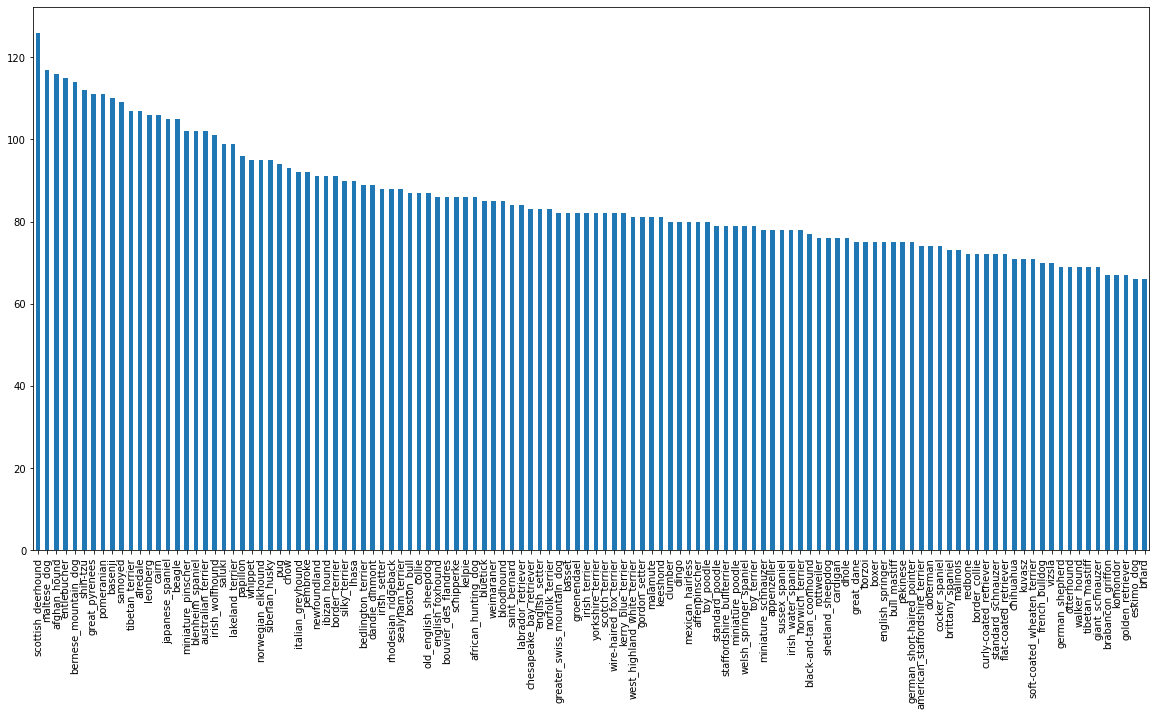

In [36]:
labels_csv.breed.value_counts().plot.bar(figsize=(20,10));

In [37]:
labels_csv.breed.value_counts().median()

82.0

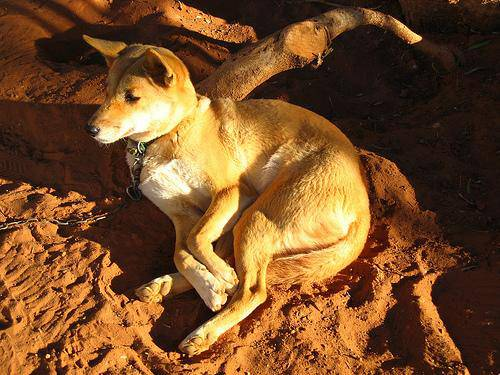

In [38]:
# Let's view an image
from IPython.display import Image
Image("drive/My Drive/DogVision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg")

### Getting Images and their labels

Let's get list of all of our image file pathnames

In [39]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [40]:
# Create  path names from image ID's
filenames = ["drive/My Drive/DogVision/train/"+fname + ".jpg" for fname in labels_csv.id]

# Check the first 10
filenames

['drive/My Drive/DogVision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/My Drive/DogVision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/My Drive/DogVision/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/My Drive/DogVision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/My Drive/DogVision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/My Drive/DogVision/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/My Drive/DogVision/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/My Drive/DogVision/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/My Drive/DogVision/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/My Drive/DogVision/train/0042188c895a2f14ef64a918ed9c7b64.jpg',
 'drive/My Drive/DogVision/train/004396df1acd0f1247b740ca2b14616e.jpg',
 'drive/My Drive/DogVision/train/0067dc3eab0b3c3ef0439477624d85d6.jpg',
 'drive/My Drive/DogVision/train/00693b8bc2470375cc744a6391d397ec.jpg',
 'drive/My Drive/DogVision/train/006cc3ddb9dc1bd827479569fcdc52d

In [41]:
# Check whether no of filenames matches no of actual image files
import os
if len(os.listdir("drive/My Drive/DogVision/train/")) == len(filenames):
  print("Matches. You can proceed")
else:
  print("Check the target directory")

Matches. You can proceed


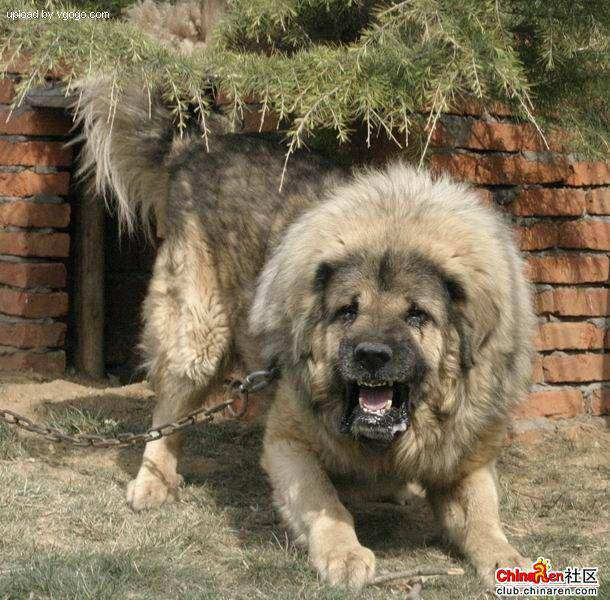

In [42]:
# One more check
Image(filenames[9000])

In [43]:
labels_csv.breed[9000]

'tibetan_mastiff'

In [44]:
import numpy as np

labels = labels_csv.breed.to_numpy()
#labels = np.array(labels)
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [45]:
len(labels)

10222

In [46]:
# See if no of labels matches with no of filenames
if len(labels) == len(labels_csv):
  print("Matches")
else:
  print("Not matches")

Matches


In [47]:
# Find unique label values
unique_breeds = np.unique(labels)
len(unique_breeds)

120

In [48]:
unique_breeds[0]

'affenpinscher'

In [49]:
# Turn a single label into an array of booleans
print(labels[0])
labels[0] == unique_breeds

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [50]:
# Turn every label to a boolean array
boolean_labels = [label == unique_breeds for label in labels]

In [51]:
boolean_labels

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [52]:
len(boolean_labels)

10222

In [53]:
# Example: Turning boolean array to integers
print(labels[0]) # original label
print(np.where(unique_breeds == labels[0])) # index where label occurs
print(boolean_labels[0].argmax()) # index where label occurs  in boolean array
print(boolean_labels[0].astype(int)) # there will be a 1 where the sample label occurs

boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


In [54]:
filenames[:10]

['drive/My Drive/DogVision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/My Drive/DogVision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/My Drive/DogVision/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/My Drive/DogVision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/My Drive/DogVision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/My Drive/DogVision/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/My Drive/DogVision/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/My Drive/DogVision/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/My Drive/DogVision/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/My Drive/DogVision/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

### Creating our own validation set

Since the dataset from Kaggle doesn't come with a validation set we've to create our own

In [55]:
# Setup X & y variables
X = filenames
y = boolean_labels

In [56]:
len(filenames)

10222

We're starting off experimenting with ~1000 images and increase as needed

In [57]:
# Set number of images to use for experimenting
NUM_IMAGES = 10020 #@param {type:"slider", min:1000, max:10022, step:10}

In [58]:
# Let's split our data into train and validation sets
from sklearn.model_selection import train_test_split

# Split them into training and validation of total size NUM_IMAGES
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES],
                                                  y[:NUM_IMAGES],
                                                  test_size=0.2,
                                                  random_state=44)

len(X_train), len(X_val), len(y_train), len(y_val)

(8016, 2004, 8016, 2004)

In [59]:
# Lets's have a geez @ training data
X_train[:2], y_train[:2]

(['drive/My Drive/DogVision/train/7282ffdad57a376830a279865a0eb487.jpg',
  'drive/My Drive/DogVision/train/d8b283801fa52bc167acb47c554e18a5.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
          True, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, Fal

## Preprocessing Images(turning images to Tensors)

To preprocess our images to Tensors we're writing a function which performs few things

1. Take an image filepath as input
2. Use TensorFlow to read the file and save it to a variable `image`
3. Turn our `image`  into Tensors
4. Normalize our `image` (convert color channel values from 0-255 to 0-1) 
5. Resize the `image` to be a shape of (224, 224)
6. Return the modified `image`

In [63]:
# Define image size
IMG_SIZE = 224

# Create a funtion for preprocessing images 
def processImage(image_path, img_size=IMG_SIZE):
  """
  Takes an image file path and turns the image to Tensor.
  """
  # Read in an image file
  image = tf.io.read_file(image_path)
  # Turn jpeg file into  numerical Tensor with RGB
  image = tf.image.decode_jpeg(image, channels=3)
  # Convert the color channel values from 0-255 to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32) 
  # Resize image to desired value (224,224)
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])
  
  return image

## Turning our data to batches

Why turn our data to batches?

Let's say you're  processing 10,000+ images in one go... they all might not fit into memory.

So that's why we do about 32 (this is the batch size) images at a time(you can manually adjust the batch size if need be).

In order to use TensorFlow  effectively, we need our data in form of Tensor tuples which look like this:

`(images, label)`

In [64]:
# Create a simple function to return a tuple (image, label)
def getImageLabel(imagePath, label):
  """
  Takes an image file path name and associated label,
  processes the imag returns a tuple of (image, label)
  """
  image = processImage(imagePath)
  return image, label

In [68]:
# Demo of the above
(processImage(X[2]), tf.constant(y[42]))

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.3918853 , 0.3918853 , 0.36051273],
         [0.43775532, 0.43775532, 0.40638277],
         [0.44351017, 0.44351017, 0.41213763],
         ...,
         [0.05796662, 0.02239764, 0.01937653],
         [0.05252095, 0.0470589 , 0.04978992],
         [0.04586835, 0.05371149, 0.04978992]],
 
        [[0.38653433, 0.38261276, 0.3630049 ],
         [0.4161569 , 0.41223532, 0.39262748],
         [0.43315482, 0.42923325, 0.4096254 ],
         ...,
         [0.0909924 , 0.05177672, 0.04754004],
         [0.03035708, 0.02489503, 0.02762605],
         [0.02370449, 0.03154762, 0.02762605]],
 
        [[0.36859885, 0.36467728, 0.34506944],
         [0.35422263, 0.35030106, 0.33069322],
         [0.39899355, 0.39507198, 0.3754641 ],
         ...,
         [0.2361781 , 0.20233706, 0.19541305],
         [0.04896353, 0.04268564, 0.04582458],
         [0.04459034, 0.04705883, 0.04582458]],
 
        ...,
 
        [[0.7591447 , 0.75522316